# Mapping participants. The first experiments

This notebook explores the participant references added to [text-fabric](https://dans-labs.github.io/text-fabric/) as extra features (see [notebook](https://github.com/ch-jensen/Semantic-mapping-of-participants/blob/master/3_Exporting%20actors%20as%20TF-features.ipynb)).

In particular, the Python package NetworkX is applied in order to visualize the networks resulting from participant references and their interactions.

## 1. Importing modules

In [1]:
import csv, collections
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa

In [5]:
locations = 'etcbc'
sources = ['bhsa', 'actor']
version = 'c'

In [11]:
modules = ['{}/{}/tf/{}'.format(locations, s, version) for s in sources]
TF = Fabric(modules=modules)

This is Text-Fabric 6.2.1
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

117 features found and 0 ignored


In [12]:
api = TF.load('''
    actor prs_actor coref
    lex gloss
    function
    sp
''')
api.makeAvailableIn(globals())
B = Bhsa(api, 'search', version="c")

  0.00s loading features ...
   |     0.12s B lex                  from C:/Users/Ejer/text-fabric-data/etcbc/bhsa/tf/c
   |     0.02s T actor                from C:/Users/Ejer/text-fabric-data/etcbc/actor/tf/c
   |     0.02s T prs_actor            from C:/Users/Ejer/text-fabric-data/etcbc/actor/tf/c
   |     0.17s T coref                from C:/Users/Ejer/text-fabric-data/etcbc/actor/tf/c
   |     0.03s B gloss                from C:/Users/Ejer/text-fabric-data/etcbc/bhsa/tf/c
   |     0.09s B function             from C:/Users/Ejer/text-fabric-data/etcbc/bhsa/tf/c
   |     0.14s B sp                   from C:/Users/Ejer/text-fabric-data/etcbc/bhsa/tf/c
  5.11s All features loaded/computed - for details use loadLog()


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="provenance of this corpus">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="BHSA feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/Bhsa/" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 6.2.1</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/#search-templates" title="Search Templates Introduction and Reference">Search Reference</a>

## 2. Mapping participant co-references

Actor references have been exported as an edge feature in text-fabric, called *coref*. By calling this edge feature a list of co-referring nodes are returned. Thereby, co-referring participant references can be mapped.

### 2.1. Setting up the system

Before network mapping, a set of functions need to defined to automate the procedure:

In [13]:
def getRefNodes(ref, level):
    '''
    Input: Tuple with book (string) and chapter (integer) plus level (phrase_atom, subphrase, or word)
    Output: A list of all nodes with edge coref features in particular chapter and at given level.
    '''
    loc = T.nodeFromSection(ref)
    
    ref_list = []
    for n in L.d(loc, level):
        if E.coref.f(n): #Using the edge feature to find co-references of the particular node.
            ref_list.append(n)
    
    return ref_list

#getRefNodes(('Leviticus',25), 'phrase_atom')

In [15]:
def writeText(node, text='gloss'):
    '''
    Input: node (word node, phrase node etc.) plus text type, that is, English gloss (default)
        or transcription of the Hebrew lexeme (= trans)
    Output: Transcription of the input node in the preferred format (trans or gloss)
    '''
    
    if F.otype.v(node) != 'word': #If not a word node, the function levels down to word level and find the lexeme or gloss.
        node_text = ''
        
        for w in L.d(node, 'word'): #Leveling down to word level
            if text == 'gloss':
                node_text += F.gloss.v(L.u(w, 'lex')[0]) + ' '
            else:
                node_text += F.lex.v(w) + ' '
    else: #Word nodes - no need to level down.
        if text == 'gloss':
            node_text = F.gloss.v(L.u(node, 'lex')[0])
        else:
            node_text = F.lex.v(node)
    return  node_text

#writeText(945735, 'trans')

In [17]:
def createTuples(node, text='gloss'):
    '''
    Input: node (word node, phrase node etc.) plus text type, that is, English gloss (default)
        or transcription of the Hebrew lexeme (= trans)
    Output: A list of tuples. Each tuple contains two nodes (transcribed) plus weight.
    '''
    edges = E.coref.f(node) #Finding co-references of the node
    tuples_list = []
    weighted_tuples_list = []
    for e in edges: #Looping over the co-references
        tup = (f' {writeText(node, text)}', writeText(e, text).rstrip(' ')) #Create tuples with node and co-references
        tuples_list.append(tup)
    
    c = collections.Counter(tuples_list) #Identical tuples are counted and condensed as weights.
    for c in c.items():
        tup = c[0][0], c[0][1], str(c[1])
        weighted_tuples_list.append(tup)
        
    return weighted_tuples_list

#createTuples(945735, 'trans')

In [48]:
def actorNetwork(actor, ref):
    '''
    This functions finds the first relevant node from the input of a reference word string. Using this function, the user
    can use actor names instead of (word/phrase atom) nodes.
    Input: Actor name (string) and Biblical reference (tuple with book and chapter)
    Output: Node
    '''
    ph_atom_list = L.d(T.nodeFromSection(ref), 'phrase_atom') #Create a phrase atom list from Biblical reference

    for ph in ph_atom_list: #Looping through the phrase atoms
        actor_node = int()

        #check phrase_atom level
        if F.actor.v(ph) == actor: #If there is a match of actor name at phrase atom level this phrase node is used
            actor_node = ph
            break

        #check subphrase level
        for subph in L.d(ph, 'subphrase'): #Going down to subphrase level to check for match
            if F.actor.v(subph) == actor:
                actor_node = subph
                break

        #check word level
        for w in L.d(ph, 'word'): #Going down to word level to check for match
            if F.actor.v(w) == actor or F.prs_actor.v(w) == actor:
                actor_node = w
                break
                
    if not actor_node: return 'Error: Actor not found' #Error if no match
            
    else: return actor_node
    
#actorNetwork('BN JFR>L', ('Leviticus', 25))  

### 2.2. Plotting

Having set up the ancillary functions, we can now start plotting co-references in network graphs. The following function creates nodes, weighted edges, node labels (lexeme or gloss), edge labels (weights). The graph is inspired by [https://qxf2.com/blog/drawing-weighted-graphs-with-networkx/](https://qxf2.com/blog/drawing-weighted-graphs-with-networkx/)

In [50]:
def plot_weighted_graph(node, label_text='gloss'):
    '''
    Input: node (word node, phrase node etc.) plus preferred text type, that is, English gloss (default)
        or transcription of the Hebrew lexeme (= trans)
    Output: weighted network graph
    '''
    bo, ch, ve = T.sectionFromNode(node) #Biblical reference deduced from node
 
    #1. Add nodes
    G = nx.Graph() #Create a graph object called G
    node_list = [writeText(e, label_text).rstrip(' ') for e in E.coref.f(node)] #Creating node list from edges
    node_list.append(f' {writeText(node, label_text)}') #Appending input node to node list
    node_list = set(node_list)
    for n in node_list: #Add nodes to graph
        G.add_node(n)
 
    #2. Selecing graph layout
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color='gold',node_size=2500) #Drawing nodes
 
    #3. Adding labels. The node names are used as labels.
    labels = {}
    for node_name in node_list:
        labels[str(node_name)] = node_name
    nx.draw_networkx_labels(G,pos,labels,font_size=12)
 
    #4. Adding weighted edges using the function createTuples()
    for e in createTuples(node, label_text):
        G.add_edge(e[0],e[1],weight=e[2])
  
    #4 a. Iterate through the graph nodes to gather all the weights
    all_weights = []
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(int(data['weight'])) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if int(edge_attr['weight'])==weight]
        
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        width = weight*len(node_list)*3.0/sum(all_weights)
        
        #4 f. Creating a dictionary with weights as edge labels. A tuple of nodes is used as key.
        edge_labels = {(node1,node2): edge_attr['weight'] for (node1,node2,edge_attr) in G.edges(data=True) if int(edge_attr['weight'])==weight}
        
        #Drawing edges and edge labels:
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)       

    plt.axis('off')
    plt.rcParams["figure.figsize"] = (10,10)
    plt.title(f'Coreferences of {writeText(node, label_text).rstrip(" ")} in {bo} {ch}', fontsize=20)
    plt.savefig(f'Images/coref_{writeText(node, label_text).rstrip(" ")}_{bo}_{ch}.png', dpi=500)
    plt.show()

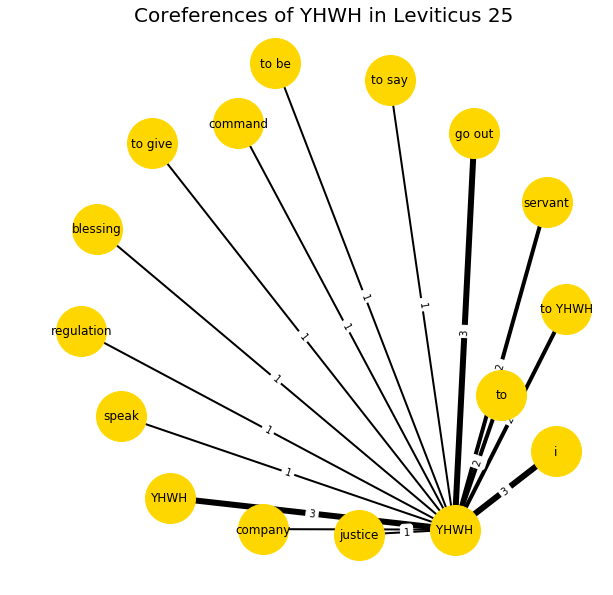

In [51]:
plot_weighted_graph(945735, 'gloss')

If one does not know the node of the actor to map with its co-references, the function actorNetwork() can be used to find the relevant node based on actor name and chapter:

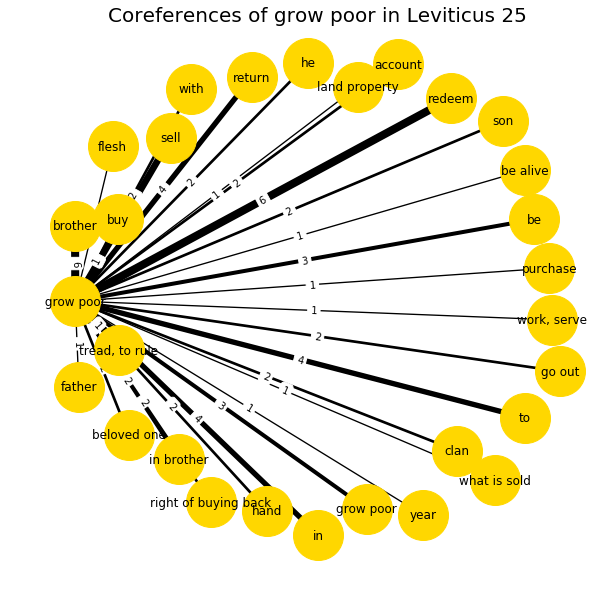

In [52]:
plot_weighted_graph(actorNetwork('>X BN JFR>L', ('Leviticus', 25)), 'gloss')

## 3. Participants in interactions

Network analysis is usually based on interactions or relations between a set of participants. When using the ETCBC database of the Hebrew text as the corpus, we adopt a well-defined concept of interactions, namely the verbs that describe relations and interactions between participants.

The following function takes a list of nodes, each referring to distinct actors in the same chapter, and identify those clauses where the actors intersect (NB: all actors need not intersecting in the same clause. It is enough that only two of them intersect). The interactions are mapped as verbs that connect participants.

In [61]:
def plot_participant_relations(node_list, label_text='gloss'):
    '''
    Input: node list (word node, phrase node etc.) plus preferred text type, that is, English gloss (default)
        or transcription of the Hebrew lexeme (= trans)
    Output: network graph
    '''    

    G = nx.MultiGraph() #Create a graph object called G
    bo, ch, ve = T.sectionFromNode(node_list[0]) #Biblical reference deduced from node
    
    #Finding intersection between nodes
    actor_names = ''
    clause_atom_node_list = []
    for n in node_list:
        actor_names += f'{writeText(n, label_text).rstrip(" ")}_' #Writing actor names to use for image name
        actor_clause_nodes = [L.u(n, 'clause_atom')[0] for n in E.coref.f(n)] #Finding the clause node of each node
        actor_clause_nodes.append(L.u(n, 'clause_atom')[0]) #Appending clause node to list
        clause_atom_node_list += list(set(actor_clause_nodes)) #Using set() to avoid redundant clause nodes
        
    #Intersections are calculated by counting the frequency of unique clauses. If a clause appears more than once, there is
    #an intersection
    counter = collections.Counter(clause_atom_node_list)
    intersection = [n for n in counter if counter[n] > 1]
         
    pred_actor_list = []
    edge_labels = {}
    if intersection:
        for cl in intersection: #Looping over clauses with intersecting actors
            non_pred_dict = {}
            pred_actor = ''
            subj = False
            for ph in L.d(cl, 'phrase'): #Looping over phrases of clause
                
                #If predicate phrase:
                if F.function.v(ph) in ['Pred','PreS','PreO']:
                    pred_actor = ph
                    pred_actor_list.append(ph)
                    
                    #The predicate phrase node is also added to non_pred_dict because the predicate contains an impl. subject
                    non_pred_dict[L.u(ph, 'phrase_atom')[0]] = F.actor.v(L.u(ph, 'phrase_atom')[0])
                    for w in L.d(ph, 'word'): #Checking whether a possible pron. suffix has an actor reference.
                        if F.prs_actor.v(w) != None:
                            non_pred_dict[L.u(ph, 'phrase_atom')[0]] = F.prs_actor.v(w) #Adding to non_pred_dict
                            
                #If complement or object phrase
                elif len(L.u(ph, 'phrase_atom')) > 0 and F.function.v(ph) in ['Cmpl', 'Objc']:
                    if F.actor.v(L.u(ph, 'phrase_atom')[0]) != None: #If actor reference, adding to dict.
                        non_pred_dict[L.u(ph, 'phrase_atom')[0]] = F.actor.v(L.u(ph, 'phrase_atom')[0])
                    else: #If no reference at phrase_atom level, checking whether there is a reference on suffix level
                        for w in L.d(ph, 'word'):
                            if F.sp.v(w) == 'prep' and F.prs_actor.v(w) != None: #Needs to be a preposition.
                                non_pred_dict[L.u(ph, 'phrase_atom')[0]] = F.prs_actor.v(w)
                            
                #If explicit subject in clause, the variable subj is set to True
                if F.function.v(ph) == 'Subj':
                    subj = True
            
            #If there is a predicate clause, edges can be created:
            if pred_actor != '':
                for n in non_pred_dict: #Creating edges from verb (pred_actor) to each relevant non-predicate of the clause
                    G.add_edge(writeText(pred_actor, label_text).rstrip(), non_pred_dict[n])
                    
                    func = F.function.v(L.d(n, 'phrase')[0])
                    if func in ['Pred','PreO','PreS']:
                        if subj == False: #If no explicit subject, set func to 'impl subj'
                            func = 'Impl. subj'                            
                        else:
                            func = 'Subj'
                    
                    #Writing edge labels as a dictionary. The phrase function is the edge value
                    edge_labels[writeText(pred_actor, label_text).rstrip(), non_pred_dict[n]] = func
        
        #3. Adding labels, using the node names
        labels = {}
        for node_name in G.nodes():
            labels[str(node_name)] = node_name

        #Using the pred_actor_list to create a list with the right names suitable for coloring the verb nodes.
        pred_actor_color = [writeText(n, label_text).rstrip(' ') for n in pred_actor_list]
        
        pos=nx.spring_layout(G)
        nx.draw_networkx_nodes(G,pos, node_color='gold',node_size=1000)
        nx.draw_networkx_nodes(G,pos,nodelist=pred_actor_color, node_color='salmon',node_size=1000)
        nx.draw_networkx_labels(G,pos,labels,font_size=8)
        nx.draw_networkx_edges(G,pos)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, font_size=8)
        
        plt.axis('off')
        plt.legend(('Participant','Predicate'), loc = 'best', numpoints = 1, markerscale = 0.4)
        plt.savefig(f'Images/network_{actor_names}{bo}_{ch}.png', dpi=500)
        plt.show()

### 3.1. Examples of mapping

Mapping YHWH and Moses in Lev 25:

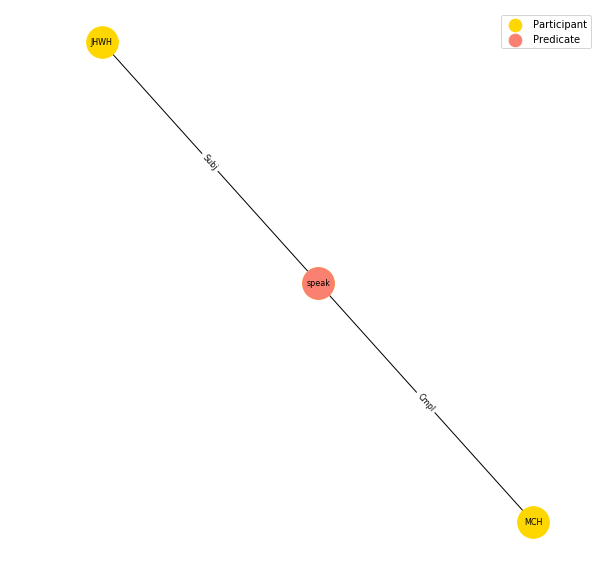

In [64]:
plot_participant_relations([actorNetwork('MCH', ('Leviticus', 25)), 
                                    actorNetwork('JHWH', ('Leviticus', 25))])

Mapping Moses and the sons of Israel in Lev 25:

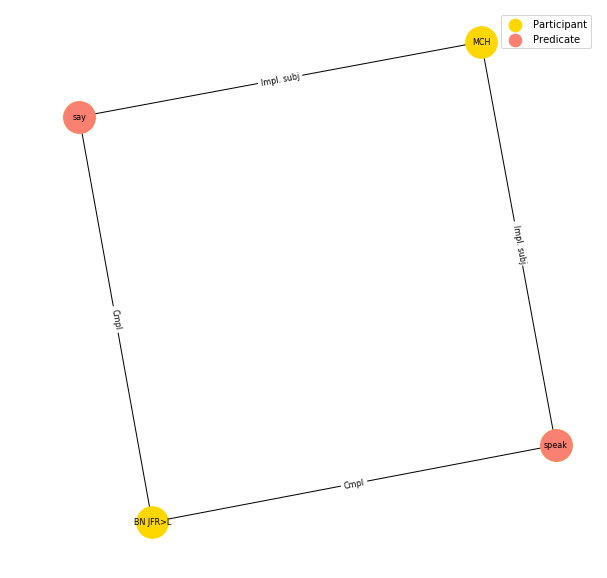

In [65]:
plot_participant_relations([actorNetwork('MCH', ('Leviticus', 25)), 
                                    actorNetwork('BN JFR>L', ('Leviticus', 25))])

Mapping YHWH, Moses and the sons of Israel in Lev 25:

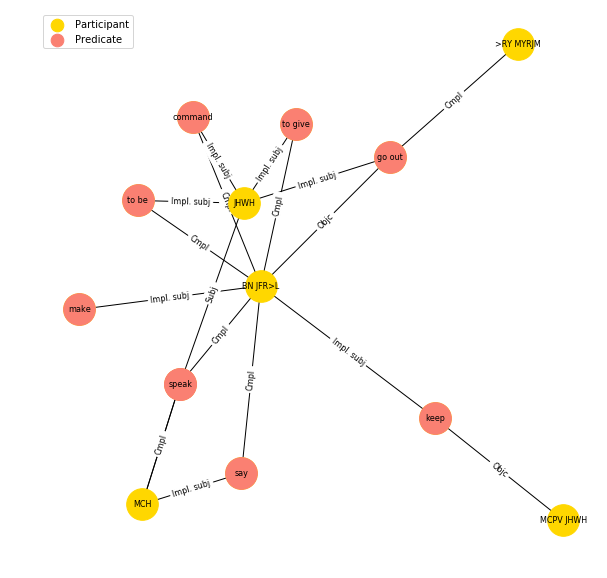

In [69]:
plot_participant_relations([actorNetwork('MCH', ('Leviticus', 25)), 
                            actorNetwork('JHWH', ('Leviticus', 25)),
                            actorNetwork('BN JFR>L', ('Leviticus', 25))])